In [253]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style("darkgrid")
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import random

import warnings
warnings.filterwarnings('ignore')

#Auxiliares

def far_to_cel(temp):
    return 5*(temp)/9 - 5*32/9


#Función para sacar outliers
#(se puede cambiar eso de s-s.mean <= etc, esa es una forma posible de detectar outliers)

def mascara_outliers(s, mult):
    return abs(s - s.mean()) <= mult*s.std()

def sacar_outliers(datos,tag,mult):
    mascara = mascara_outliers(datos[tag], mult)
    return datos[mascara]


#Función para delimitar ejes:
#(dice dominio, pero se puede usar para imagen también... ya se que esta medio cabeza, pero anda bien)

def mascara_dominio_abajo(s,x0):
    return x0 <= s
def mascara_dominio_arriba(s,x1):
    return s <= x1

def achicar_dominio(datos,tag,x0,x1):
    mascara = mascara_dominio_abajo(datos[tag],x0)
    datos = datos[mascara]
    mascara = mascara_dominio_arriba(datos[tag],x1)
    return datos[mascara]


#Función para crear una columna con cada año
#(es imrpotante haber cargado el csv con el arguemtno parse_dates=[tag])
def crear_col_años(datos,tag):
    return datos[tag].apply (lambda x : x.year if x.month <= 12 else x.year + 1)


#Cuadrados mínimos para predecir

def armar_matriz_A(s):
    temp = []
    for t in s:
        #polo sur
        temp.append([t**4, t**3, t**2, t, 1, np.sin(-70*t-1000)]) #v1
        #temp.append([t^3, t^2, t, 1, np.cos(t)]) #v2
        
        #nivel del agua zoom
        #temp.append([t, 1, np.sin(t**2), np.cos(t**2)]) #v1
        #temp.append([t**2, np.sin(t), t, 1])
        
        
    return np.array(temp)

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion, tag1, tag2):
    regr = linear_model.LinearRegression(fit_intercept=False)

    # Entreno el modelo
    df_e = df[df[tag1].isin(rango_entrenamiento)]
    A_e = armar_matriz_A(df_e[tag1])
    regr.fit(A_e, df_e[tag2])

    # Me fijo la aproximación que se realizó
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e[tag1], data=df_e['p'], color='r')

    # Realizo predicciones
    df_p = df[df[tag1].isin(rango_prediccion)]

    A_p = armar_matriz_A(df_p[tag1])
    df_p['p'] = regr.predict(A_p)
    sns.tsplot(time=df_p[tag1], data=df_p['p'], color='g')

    ECM = sum((df_p['p']-df_p[tag2])**2)
    return ECM

def predecir(datos, k, rango,limitador, tag1, tag2):
    return entrenar_y_predecir_en_rangos(datos, range(k-rango,k), range(k,k+rango-limitador), tag1, tag2)


def graficador(datos, año, rango, limitador, x0, x1, tag1, tag2, title, xl, yl):
    ECM = predecir(datos,año,rango,limitador,tag2, tag1)
    print("Error de predicción: {:.2f}".format(ECM))
    
    sns.plt.title(title)
    sns.plt.xlabel(xl)
    sns.plt.ylabel(yl)
    
    sns.plt.xlim((x0,x1))
    sns.plt.show()
    sns.plt.close()


#Auxiliares

def descripcion(datos):
    print(datos.describe())

def ver_filas(datos, fil):
    print(datos.head(fil))

Error de predicción: 148.23


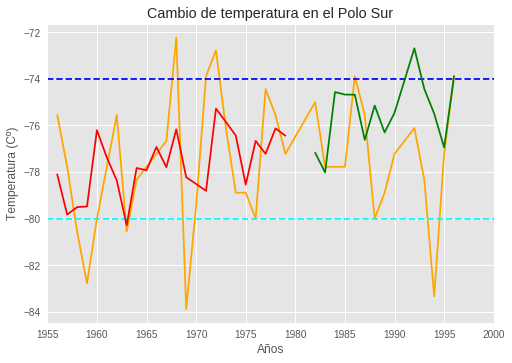

Error de predicción: 0.39


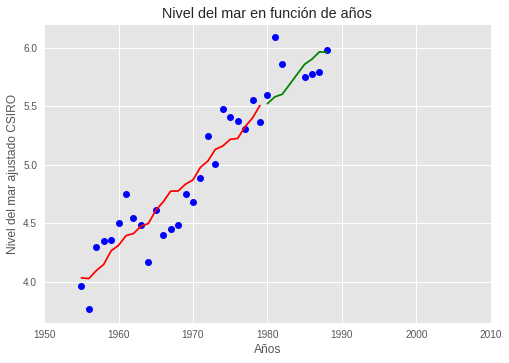

Error de predicción: nan


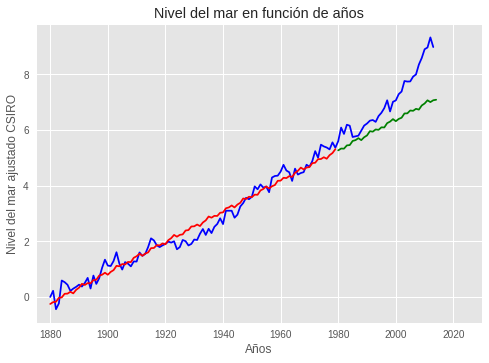

In [254]:
#=======================================#
# EXPERIMENTOS DE POLOS Y NIVEL DEL MAR #
#=======================================#


################################
# Levanto los datos, y los veo #
################################

df = pd.read_csv('../data/temperaturas_catedra/GlobalLandTemperaturesByCountry.csv', parse_dates=['dt'])

df_south_pole = pd.read_csv('../data/polos/temperaturas/south_pole.csv')


#df_greenland = df[df['Country'] == 'Greenland'].reset_index()
#df_greenland['year'] = crear_col_años(df_greenland, "dt")
#df_greenland = df_greenland.groupby(['year']).mean().reset_index()
#al final no uso Groenlandia, Pausa lo aprueba.

df_sl_global = pd.read_csv('../data/polos/sea_level/global.csv')



#####################
# Grafico los datos #
#####################

#Polo sur

#convirtiendo todo a celsius
for i in range(0,41):
    df_south_pole.ix[i, 'temp'] = far_to_cel(df_south_pole.ix[i, 'temp'])
    #print(df_south_pole.ix[i, 'temp'])
    
df_south_pole = sacar_outliers(df_south_pole, 'temp', 1)

ax = sns.tsplot(data=df_south_pole['temp'], time=df_south_pole['year'], interpolate=True, color='orange')
sns.plt.plot((1955, 2000), (-74, -74), color='blue', linestyle='dashed')
sns.plt.plot((1955, 2000), (-80, -80), color='cyan', linestyle='dashed')
graficador(df_south_pole, 1980, 30, 0, 1955, 2000, 'temp', 'year', 'Cambio de temperatura en el Polo Sur', 'Años', 'Temperatura (Cº)')


#Nivel del mar

df_sl_global_gen = df_sl_global #lo guardo para el ultimo de estos

df_sl_global = sacar_outliers(df_sl_global, 'CSIRO Adjusted Sea Level', 1)

df_sl_global = achicar_dominio(df_sl_global, 'Year', 1955, 2000)

sns.tsplot(data=df_sl_global['CSIRO Adjusted Sea Level'], time=df_sl_global['Year'], interpolate=False, color='b')
graficador(df_sl_global, 1980, 30, 0, 1950, 2010, 'CSIRO Adjusted Sea Level', 'Year', 'Nivel del mar en función de años', 'Años', 'Nivel del mar ajustado CSIRO')


#Nivel del mar en general

sns.tsplot(data=df_sl_global_gen['CSIRO Adjusted Sea Level'], time=df_sl_global_gen['Year'], interpolate=True, color='b')
graficador(df_sl_global_gen, 1980, 100, 0, 1875, 2030, 'CSIRO Adjusted Sea Level', 'Year', 'Nivel del mar en función de años', 'Años', 'Nivel del mar ajustado CSIRO')



In [ ]:
#Cargamos las ciudades acá porque pesan mucho
dfc = pd.read_csv('../data/temperaturas_catedra/GlobalLandTemperaturesByCity.csv', parse_dates=['dt'])

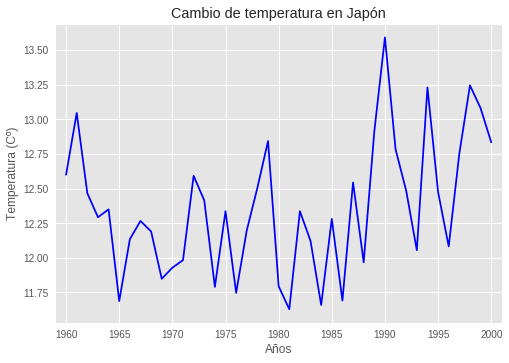

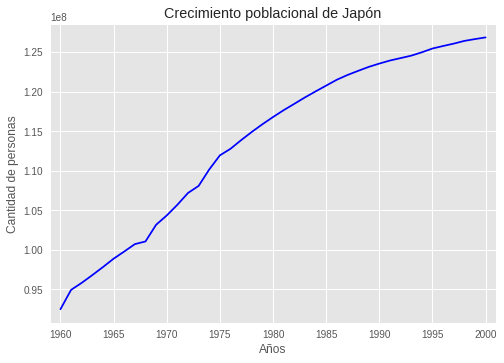

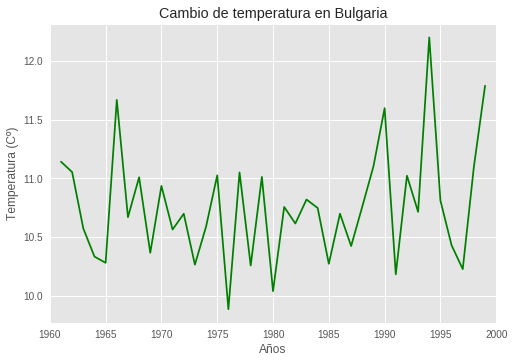

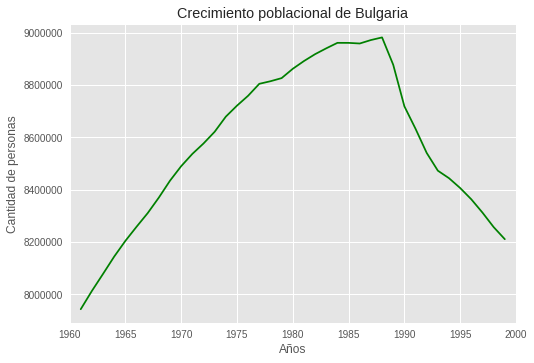

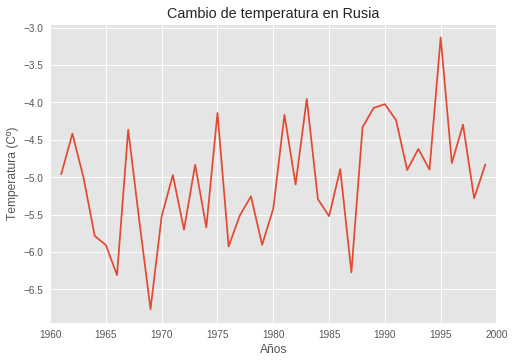

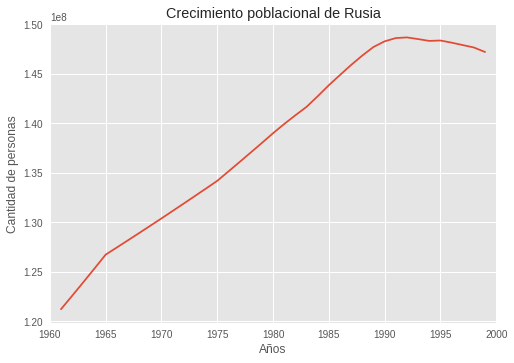

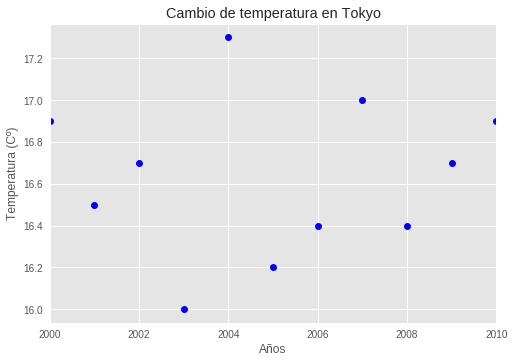

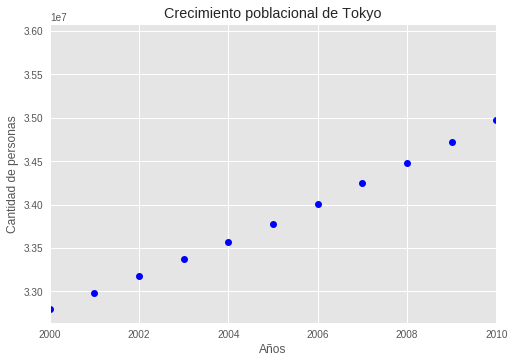

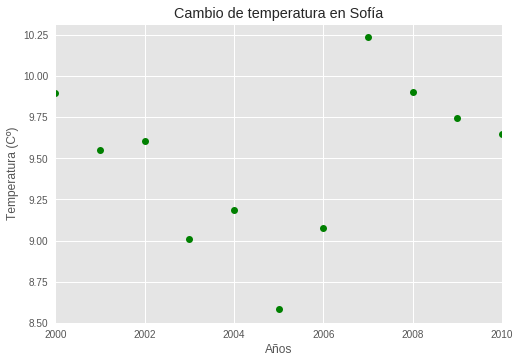

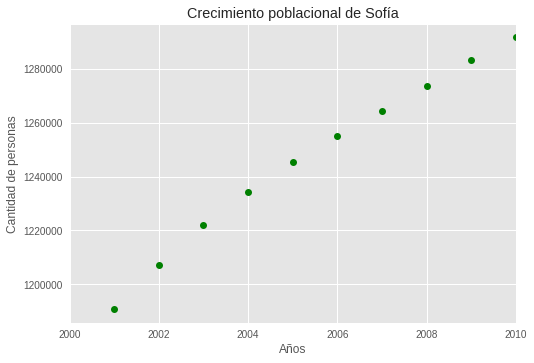

In [222]:
#===========================#
# EXPERIMENTOS DE POBLACIÓN #
#===========================#

#observaciones: modularizar mas la parte de levantar datos y graficar (también para el anterior y siguiente bloque)

################################
# Levanto los datos, y los veo #
################################


# Por país

df = pd.read_csv('../data/temperaturas_catedra/GlobalLandTemperaturesByCountry.csv', parse_dates=['dt'])

df_poblacion = pd.read_csv('../data/population/population_by_region.csv')

#Regiones con alto crecimiento:

df_japan_t = df[df['Country'] == 'Japan'].reset_index()
df_japan_t['year'] = crear_col_años(df_japan_t, "dt")
df_japan_t = achicar_dominio(df_japan_t,'year',1960,2000)
df_japan_t = df_japan_t.groupby(['year']).mean().reset_index()
df_japan_p = df_poblacion[df_poblacion['Country Name'] == 'Japan'].reset_index()
df_japan_p = achicar_dominio(df_japan_p,'Year',1960,2000)

df_india_t = df[df['Country'] == 'India'].reset_index()
df_india_t['year'] = crear_col_años(df_india_t, "dt")
df_india_t = achicar_dominio(df_india_t,'year',1960,2000)
df_india_t = df_india_t.groupby(['year']).mean().reset_index()
df_india_p = df_poblacion[df_poblacion['Country Name'] == 'India'].reset_index()
df_india_p = achicar_dominio(df_india_p,'Year',1960,2000)

df_afghanistan_t = df[df['Country'] == 'Afghanistan'].reset_index()
df_afghanistan_t['year'] = crear_col_años(df_afghanistan_t, "dt")
df_afghanistan_t = achicar_dominio(df_afghanistan_t,'year',1960,2000)
df_afghanistan_t = df_india_t.groupby(['year']).mean().reset_index()
df_afghanistan_p = df_poblacion[df_poblacion['Country Name'] == 'Afghanistan'].reset_index()
df_afghanistan_p = achicar_dominio(df_afghanistan_p,'Year',1960,2000)

#Regiones con bajo crecimiento:

df_fed_rusia_t = df[df['Country'] == 'Russia'].reset_index()
df_fed_rusia_t['year'] = crear_col_años(df_fed_rusia_t, "dt")
df_fed_rusia_t = achicar_dominio(df_fed_rusia_t,'year',1960,2000)
df_fed_rusia_t = df_fed_rusia_t.groupby(['year']).mean().reset_index()
df_fed_rusia_p = df_poblacion[df_poblacion['Country Name'] == 'Russian Federation'].reset_index()
df_fed_rusia_p = achicar_dominio(df_fed_rusia_p,'Year',1960,2000)

df_bulgaria_t = df[df['Country'] == 'Bulgaria'].reset_index()
df_bulgaria_t['year'] = crear_col_años(df_bulgaria_t, "dt")
df_bulgaria_t = achicar_dominio(df_bulgaria_t,'year',1960,2000)
df_bulgaria_t = df_bulgaria_t.groupby(['year']).mean().reset_index()
df_bulgaria_p = df_poblacion[df_poblacion['Country Name'] == 'Bulgaria'].reset_index()
df_bulgaria_p = achicar_dominio(df_bulgaria_p,'Year',1960,2000)


# Por ciudad en país

#Para Tokio, Japon

dfc_tokyo_p = pd.read_csv('../data/population/population_tokyo.csv')

dfc_tokyo_t = pd.read_csv('../data/population/temperature_tokyo.csv')

#Para Sofia, Bulgaria

dfc_sofia_p = pd.read_csv('../data/population/population_sofia.csv')

dfc_sofia_t = dfc[dfc['City'] == 'Sofia'].reset_index()
dfc_sofia_t['year'] = crear_col_años(dfc_sofia_t, "dt")
dfc_sofia_t = achicar_dominio(dfc_sofia_t,'year',2000,2010)
dfc_sofia_t = dfc_sofia_t.groupby(['year']).mean().reset_index()


#####################
# Grafico los datos #
#####################

#Por pais

#Para Japon

#df_japan_t = sacar_outliers(df_japan_t, 'AverageTemperature', 1)

ax = sns.tsplot(data=df_japan_t['AverageTemperature'], time=df_japan_t['year'], interpolate=True, color='b')
sns.plt.xlim((1959,2001))
sns.plt.title('Cambio de temperatura en Japón')
sns.plt.xlabel('Años')
sns.plt.ylabel('Temperatura (Cº)')
sns.plt.show()
sns.plt.close()

ax = sns.tsplot(data=df_japan_p['Value'], time=df_japan_p['Year'], interpolate=True, color='b')
sns.plt.xlim((1959,2001))
sns.plt.title('Crecimiento poblacional de Japón')
sns.plt.xlabel('Años')
sns.plt.ylabel('Cantidad de personas')
sns.plt.show()
sns.plt.close()


#Para Bulgaria

#df_japan_t = sacar_outliers(df_japan_t, 'AverageTemperature', 1)

df_bulgaria_t = achicar_dominio(df_bulgaria_t,'year',1961,1999)

ax = sns.tsplot(data=df_bulgaria_t['AverageTemperature'], time=df_bulgaria_t['year'], interpolate=True, color='g')
sns.plt.xlim((1960,2000))
sns.plt.title('Cambio de temperatura en Bulgaria')
sns.plt.xlabel('Años')
sns.plt.ylabel('Temperatura (Cº)')
sns.plt.show()
sns.plt.close()

df_bulgaria_p = achicar_dominio(df_bulgaria_p,'Year',1961,1999)

ax = sns.tsplot(data=df_bulgaria_p['Value'], time=df_bulgaria_p['Year'], interpolate=True, color='g')
sns.plt.xlim((1960,2000))
sns.plt.title('Crecimiento poblacional de Bulgaria')
sns.plt.xlabel('Años')
sns.plt.ylabel('Cantidad de personas')
sns.plt.show()
sns.plt.close()

#Para Rusia

#df_japan_t = sacar_outliers(df_japan_t, 'AverageTemperature', 1)

df_fed_rusia_t = achicar_dominio(df_fed_rusia_t,'year',1961,1999)

ax = sns.tsplot(data=df_fed_rusia_t['AverageTemperature'], time=df_fed_rusia_t['year'], interpolate=True)
sns.plt.xlim((1960,2000))
sns.plt.title('Cambio de temperatura en Rusia')
sns.plt.xlabel('Años')
sns.plt.ylabel('Temperatura (Cº)')
sns.plt.show()
sns.plt.close()

df_fed_rusia_p = achicar_dominio(df_fed_rusia_p,'Year',1961,1999)

ax = sns.tsplot(data=df_fed_rusia_p['Value'], time=df_fed_rusia_p['Year'], interpolate=True)
sns.plt.xlim((1960,2000))
sns.plt.title('Crecimiento poblacional de Rusia')
sns.plt.xlabel('Años')
sns.plt.ylabel('Cantidad de personas')
sns.plt.show()
sns.plt.close()


#Por ciudad en pais

#Tokyo

#dfc_tokyo_t = sacar_outliers(dfc_tokyo_t, 'AverageTemperature', 1)

ax = sns.tsplot(data=dfc_tokyo_t['Value'], time=dfc_tokyo_t['Year'], interpolate=False, color='b')
sns.plt.xlim((2000,2010))
sns.plt.title('Cambio de temperatura en Tokyo')
sns.plt.xlabel('Años')
sns.plt.ylabel('Temperatura (Cº)')
sns.plt.show()
sns.plt.close()

ax = sns.tsplot(data=dfc_tokyo_p['Value'], time=dfc_tokyo_p['Year'], interpolate=False, color='b')
sns.plt.xlim((2000,2010))
sns.plt.title('Crecimiento poblacional de Tokyo')
sns.plt.xlabel('Años')
sns.plt.ylabel('Cantidad de personas')
sns.plt.show()
sns.plt.close()

#Sofia

#dfc_sofia_t = sacar_outliers(dfc_sofia_t, 'AverageTemperature', 1)

ax = sns.tsplot(data=dfc_sofia_t['AverageTemperature'], time=dfc_sofia_t['year'], interpolate=False, color='g')
sns.plt.xlim((2000,2010))
sns.plt.title('Cambio de temperatura en Sofía')
sns.plt.xlabel('Años')
sns.plt.ylabel('Temperatura (Cº)')
sns.plt.show()
sns.plt.close()

ax = sns.tsplot(data=dfc_sofia_p['Value'], time=dfc_sofia_p['Year'], interpolate=False, color='g')
sns.plt.xlim((2000,2010))
sns.plt.title('Crecimiento poblacional de Sofía')
sns.plt.xlabel('Años')
sns.plt.ylabel('Cantidad de personas')
sns.plt.show()
sns.plt.close()


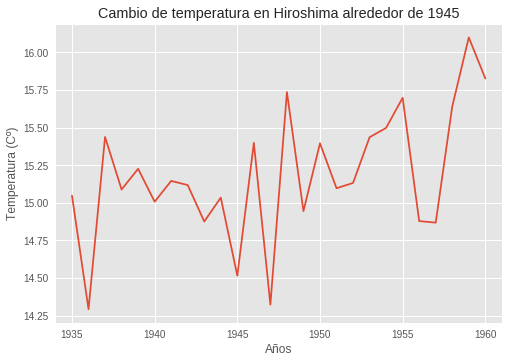

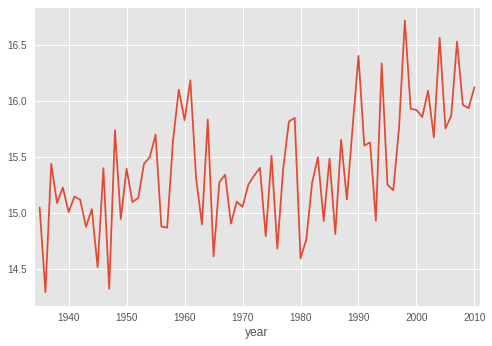

In [223]:
#=========================#
# EXPERIMENTACIÓN ATÓMICA #
#=========================#


################################
# Levanto los datos, y los veo #
################################


dfc_hiroshima = dfc[dfc['City'] == 'Hiroshima'].reset_index()
dfc_hiroshima['year'] = crear_col_años(dfc_hiroshima, "dt")
dfc_hiroshima = dfc_hiroshima.groupby(['year']).mean().reset_index()


#####################
# Grafico los datos #
#####################


dfc_hiroshima_zoom = achicar_dominio(dfc_hiroshima,'year',1935,1960)

#dfc_hiroshima_zoom = sacar_outliers(dfc_hiroshima_zoom, 'AverageTemperature', 1)

ax = sns.tsplot(data=dfc_hiroshima_zoom['AverageTemperature'], time=dfc_hiroshima_zoom['year'], interpolate=True)
sns.plt.xlim((1934,1961))
sns.plt.title('Cambio de temperatura en Hiroshima alrededor de 1945')
sns.plt.xlabel('Años')
sns.plt.ylabel('Temperatura (Cº)')
sns.plt.show()
sns.plt.close()



dfc_hiroshima = achicar_dominio(dfc_hiroshima,'year',1935,2010)

ax = sns.tsplot(data=dfc_hiroshima['AverageTemperature'], time=dfc_hiroshima['year'], interpolate=True)
sns.plt.xlim((1934,2011))
sns.plt.show()
sns.plt.close()
